In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import interpolate
color = sns.color_palette()
%matplotlib inline
import sys  
reload(sys)
sys.setdefaultencoding('gbk') 
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [17]:
train=pd.read_csv("round2_train.txt",sep=" ")
test_a=pd.read_csv("round2_ijcai_18_test_a_20180425.txt",sep=" ")
test_b=pd.read_csv("round2_ijcai_18_test_b_20180510.txt",sep=" ")

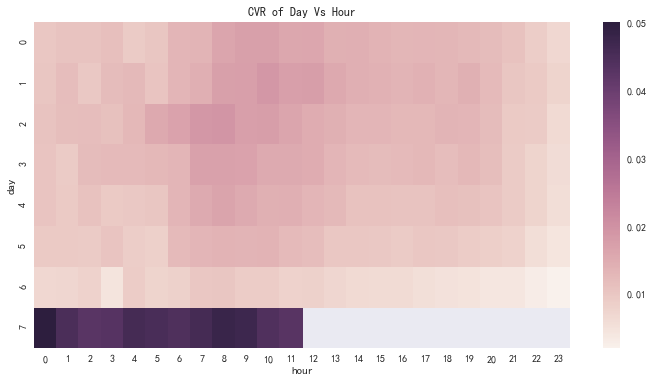

In [18]:
import time
train["time_sting"]=train["context_timestamp"].apply(lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x)))
train["time_sting"]=pd.to_datetime(train["time_sting"])
train["hour"]=train["time_sting"].dt.hour
train["day"]=train["time_sting"].dt.day
train["day"]=train["day"].apply(lambda x:0 if x==31 else x)

grouped_df = train.groupby(["day", "hour"])["is_trade"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'is_trade')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("CVR of Day Vs Hour")
plt.show()


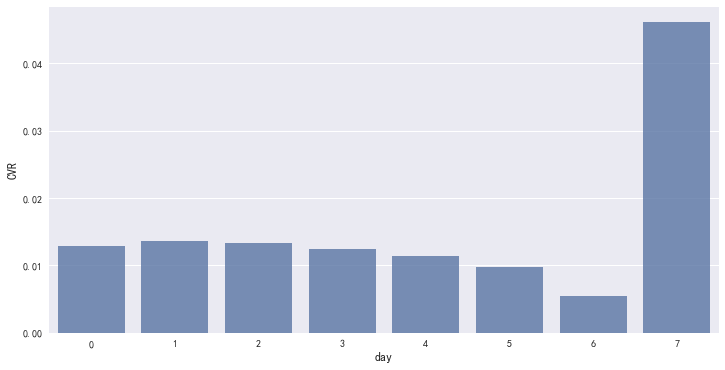

In [19]:
cnt_srs=train.groupby("day").is_trade.mean()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('CVR', fontsize=12)
plt.xlabel('day', fontsize=12)
plt.show()

通过对每天每时转化率分析，前几天转化率和当天差异较大，所以直接使用最后一天的上午作为训练集。

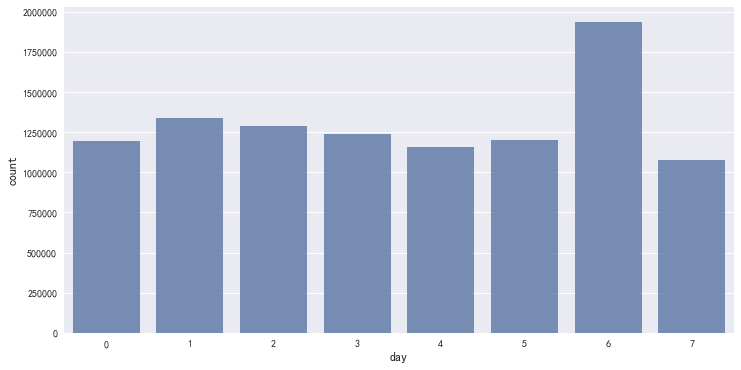

In [21]:
cnt_srs=train.groupby("day").is_trade.count()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('count', fontsize=12)
plt.xlabel('day', fontsize=12)
plt.show()

但是前七天包含了大量的数据，使用前七天提取了转化率信息，同时使用前七天的数据预测了第八天的数据，然后把预测的结果当成新的特征。

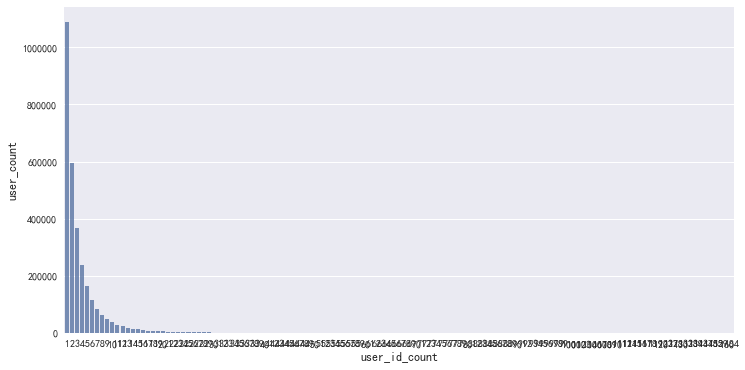

In [22]:
cnt_srs=pd.DataFrame(train.groupby("user_id").is_trade.count()).reset_index()
cnt_srs.columns=["user_id","user_id_count"]

cnt_srs=cnt_srs.groupby("user_id_count").user_id.count()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('user_count', fontsize=12)
plt.xlabel('user_id_count', fontsize=12)
plt.show()

发现每个人的平均次数较少，所以和通常的根据用户的历史数据预测未来是否购买问题是不一样的，没必要进行滑窗统计user_id的特征。
进一步分析，数据中包含大量的单次用户或很少次数的用户，猜测这里只是用户的搜索数据，浏览数据和点击数据不包含在里面。那么此时搜索的内容和商品的属性就是信息量存放的点了。
对于单次用户，我们只能通过他搜索的和商品实际的属性，以及品类的确定。
对于多次用户，我们能统计出用户的属性偏好，以及用户的实际想购买的偏好。
假设现在我任意选取两个属性来演示。
用下图来表示：true_p1表示p1这个属性在不在item_property_list中，pre_p1表示p1这个属性在不在predict_category_property中

In [14]:
dic={"user_id":[1,1,1,1,1,2,2,2,2,2],"true_p1":[1,1,0,1,1,0,0,0,1,0],"true_p2":[0,0,0,1,0,1,1,1,1,1],"item_id":[1,2,3,1,2,1,2,1,4,5],"pre_p1":[1,1,1,1,1,0,0,1,1,0],"pre_p2":[1,0,0,1,0,1,1,0,1,1]}

In [15]:
sample=pd.DataFrame(dic)

In [16]:
sample

,item_id,pre_p1,pre_p2,true_p1,true_p2,user_id
0,1,1,1,1,0,1
1,2,1,0,1,0,1
2,3,1,0,0,0,1
3,1,1,1,1,1,1
4,2,1,0,1,0,1
5,1,0,1,0,1,2
6,2,0,1,0,1,2
7,1,1,0,0,1,2
8,4,1,1,1,1,2
9,5,0,1,0,1,2


In [17]:
sample.groupby("user_id").true_p1.mean()

user_id
1    0.8
2    0.2
Name: true_p1, dtype: float64

In [18]:
sample.groupby("user_id").pre_p1.mean()

user_id
1    1.0
2    0.4
Name: pre_p1, dtype: float64

统计出用户对于属性的占比，我们会捕捉到用户对属性的偏好，这是特征的第二次构造。

In [20]:
for i in ["true_p1","true_p2","pre_p1","pre_p2"]:
    temp=pd.DataFrame(sample.groupby("user_id")[i].mean()).reset_index()
    temp.columns=["user_id","%s_mean_user"%i]
    sample=sample.merge(temp,on="user_id",how="left")

In [21]:
sample

,item_id,pre_p1,pre_p2,true_p1,true_p2,user_id,true_p1_mean_user,true_p2_mean_user,pre_p1_mean_user,pre_p2_mean_user
0,1,1,1,1,0,1,0.8,0.2,1.0,0.4
1,2,1,0,1,0,1,0.8,0.2,1.0,0.4
2,3,1,0,0,0,1,0.8,0.2,1.0,0.4
3,1,1,1,1,1,1,0.8,0.2,1.0,0.4
4,2,1,0,1,0,1,0.8,0.2,1.0,0.4
5,1,0,1,0,1,2,0.2,1.0,0.4,0.8
6,2,0,1,0,1,2,0.2,1.0,0.4,0.8
7,1,1,0,0,1,2,0.2,1.0,0.4,0.8
8,4,1,1,1,1,2,0.2,1.0,0.4,0.8
9,5,0,1,0,1,2,0.2,1.0,0.4,0.8


继续，我们可以统计出有这些属性偏好的人和所搜索并点击的item之间的关系

In [23]:
sample.groupby("item_id").true_p1_mean_user.mean()

item_id
1    0.5
2    0.6
3    0.8
4    0.2
5    0.2
Name: true_p1_mean_user, dtype: float64

In [24]:
sample.groupby("item_id").true_p2_mean_user.mean()

item_id
1    0.600000
2    0.466667
3    0.200000
4    1.000000
5    1.000000
Name: true_p2_mean_user, dtype: float64

In [25]:
sample.groupby("item_id").pre_p1_mean_user.mean()

item_id
1    0.7
2    0.8
3    1.0
4    0.4
5    0.4
Name: pre_p1_mean_user, dtype: float64

In [26]:
sample.groupby("item_id").pre_p2_mean_user.mean()

item_id
1    0.600000
2    0.533333
3    0.400000
4    0.800000
5    0.800000
Name: pre_p2_mean_user, dtype: float64

所以，我们又可以构造出查看该item的人对不同的属性的平均偏好，这是特征的第三次构造。

最终再加上user_id对于item_id,cate_id等的时间差特征，排序特征和计数特征等，共同构成了我的特征集。
本题核心就是根据数据的分析选用合适的数据建模，围绕着user_id和item_id构造特征，找出user_id和item_id的数据表达方法，从数据的痕迹里复现当时用户的场景。